# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [1]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2022-04-04 15:56:49--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757958 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.40M  --.-KB/s    in 0.09s   

2022-04-04 15:56:50 (80.4 MB/s) - ‘ita-eng.zip’ saved [7757958/7757958]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(353281, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [4]:
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):   
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [5]:
data = data.drop_duplicates(subset=['english','italian'])
data = data.reset_index(drop=True)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [6]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [7]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


In [8]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 25]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 25]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'
data['italian'] = '<start> ' + data['italian'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
data.head()

,italian,english_inp,english_out
0,<start> ciao <end>,<start> hi,hi <end>
1,<start> corri <end>,<start> run,run <end>
2,<start> corra <end>,<start> run,run <end>
3,<start> correte <end>,<start> run,run <end>
4,<start> chi <end>,<start> who,who <end>


In [9]:
data.sample(10)

,italian,english_inp,english_out
90967,<start> tom non è incredibile <end>,<start> is not tom incredible,is not tom incredible <end>
161151,<start> amavi cantare <end>,<start> you used to love singing,you used to love singing <end>
140917,<start> tom si sta esercitando con il piano <end>,<start> tom is practicing piano,tom is practicing piano <end>
149751,<start> ho odiato vedere tom andarsene <end>,<start> i hated to see tom leave,i hated to see tom leave <end>
339017,<start> mary dice che ha bisogno di trovare qu...,<start> mary says she needs to find someone to...,mary says she needs to find someone to help to...
149758,<start> io ho un libro in mano <end>,<start> i have a book in my hand,i have a book in my hand <end>
330195,<start> è successo un terribile incidente in s...,<start> a terrible accident happened in his ab...,a terrible accident happened in his absence <end>
30000,<start> tom è dei pesci <end>,<start> tom is a pisces,tom is a pisces <end>
18978,<start> vi amo tutti <end>,<start> i love you all,i love you all <end>
127432,<start> beh come si chiama <end>,<start> well what is it called,well what is it called <end>


> <font color="blue"><b>If we observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [10]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [11]:
print(train.shape, validation.shape)
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(279976, 3) (69995, 3)


### Teacher Forcing
<pre>
Let us consider the example data point

italian: erano occupate	
english_inp: &lt;start> they were busy	
                |     |     |    |
english_out:  they   were busy &lt;end>

if you observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out" 

with this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

</pre>

### Getting train and test 

In [12]:
train.head()

,italian,english_inp,english_out
148362,<start> è ingordo e spietato <end>,<start> he is greedy and ruthless <end>,he is greedy and ruthless <end> <end>
103998,<start> ti suggerisco di andare ad ovest <end>,<start> i suggest you go west,i suggest you go west <end>
47300,<start> io spero che loro la facciano <end>,<start> i hope they do it,i hope they do it <end>
156719,<start> tom è un po un codardo <end>,<start> tom is a bit of a coward,tom is a bit of a coward <end>
106301,<start> è davvero bella <end>,<start> it is really beautiful,it is really beautiful <end>


In [13]:
validation.head()

,italian,english_inp,english_out
310422,<start> chi è la sua musicista canadese prefer...,<start> who is your favorite canadian musician,who is your favorite canadian musician <end>
334046,<start> ci sono molti bei posti in giappone <end>,<start> there are a lot of beautiful places in...,there are a lot of beautiful places in japan <...
178513,<start> non andare là da solo <end>,<start> do not go there by yourself,do not go there by yourself <end>
77827,<start> si tolga le scarpe <end>,<start> take off your shoes,take off your shoes <end>
79949,<start> tom semplicemente non si fermerà <end>,<start> tom just will not stop,tom just will not stop <end>


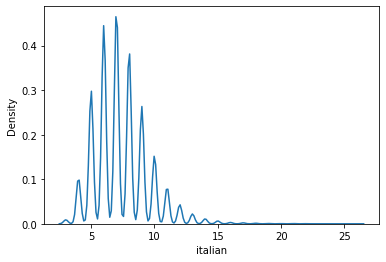

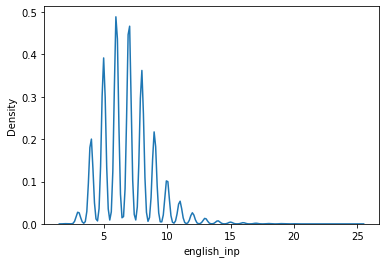

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [14]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [15]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13041
26675


In [16]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10300)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0


    def build(self,input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
    
    def call(self,input_sequence,states):
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        
    
    def initialize_states(self,batch_size):
        initial_state_h=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        initial_state_c=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        return [initial_state_h , initial_state_c]

      


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size)
           and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Encoder_LSTM")
        


    def call(self,input_sequence,initial_states):
        target_embedd = self.embedding(input_sequence)
        decoder_output, decoder_final_state_h,decoder_final_state_c = self.lstm(target_embedd, initial_state=initial_states)
        return decoder_output,decoder_final_state_h,decoder_final_state_c



<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


### Creating data pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
batch_size = 512
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 25)
validation_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 25)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
validation_dataloader = Dataloder(validation_dataset, batch_size=batch_size)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(512, 25) (512, 26) (512, 26)


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length, lstm_size=256)
        self.decoder = Decoder(vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_inputs_length, lstm_size=256)
        self.dense = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        encoder_output, encoder_h, encoder_c = self.encoder(data[0],self.encoder.initialize_states(batch_size))
        decoder_output, decoder_h, decoder_c = self.decoder(data[1], [encoder_h, encoder_c])
        output = self.dense(decoder_output)
        return output

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_Encoder_decoder = Encoder_decoder(25,26,vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model_Encoder_decoder.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size

In [ ]:

model_Encoder_decoder.fit(train_dataloader,
                     steps_per_epoch=train_steps,
                     epochs=20,
                     validation_data=validation_dataloader,
                     validation_steps=valid_steps,
                     callbacks=[tensorboard_callback],
                     verbose=1)


Epoch 1/20
546/546 [==============================] - 164s 281ms/step - loss: 1.2792 - val_loss: 1.0546
Epoch 2/20
546/546 [==============================] - 151s 277ms/step - loss: 0.9421 - val_loss: 0.8513
Epoch 3/20
546/546 [==============================] - 149s 272ms/step - loss: 0.7820 - val_loss: 0.7193
Epoch 4/20
546/546 [==============================] - 153s 280ms/step - loss: 0.6605 - val_loss: 0.6196
Epoch 5/20
546/546 [==============================] - 148s 272ms/step - loss: 0.5621 - val_loss: 0.5353
Epoch 6/20
546/546 [==============================] - 148s 272ms/step - loss: 0.4768 - val_loss: 0.4653
Epoch 7/20
546/546 [==============================] - 148s 272ms/step - loss: 0.4053 - val_loss: 0.4056
Epoch 8/20
546/546 [==============================] - 148s 272ms/step - loss: 0.3459 - val_loss: 0.3603
Epoch 9/20
546/546 [==============================] - 148s 272ms/step - loss: 0.2969 - val_loss: 0.3221
Epoch 10/20
546/546 [==============================] - 148s 271m

In [ ]:
model_Encoder_decoder.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1650218   
                                                                 
 decoder_1 (Decoder)         multiple                  1677468   
                                                                 
 dense (Dense)               multiple                  3371326   
                                                                 
Total params: 6,699,012
Trainable params: 6,699,012
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def predict(input_sentence):
    tokens = tknizer_ita.texts_to_sequences(np.expand_dims(input_sentence,0))
    enc_output, enc_state_h, enc_state_c = model_Encoder_decoder.layers[0](np.array(tokens),states=None)
    states_values = [enc_state_h, enc_state_c]
    pred = []
    cur_vec = np.zeros((1, 1))
    for i in range(26):
        cur_emb = model_Encoder_decoder.layers[1].embedding(cur_vec)
        infe_output, state_h, state_c = model_Encoder_decoder.layers[1].lstm(cur_emb, initial_state=states_values)
        infe_output=model_Encoder_decoder.layers[2](infe_output)
        states_values = [state_h, state_c]
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        pred.append(cur_vec)
        
    return(pred)

In [ ]:
for index, row in validation.sample(5).iterrows():
    pred = predict(row['italian'])
    pred_seq = [[i[0][0] for i in pred if i[0][0] != tknizer_eng.word_index['<end>']][1:]]
    print('='*80)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Predicted Translation: ",tknizer_eng.sequences_to_texts(pred_seq)[0])

Italian Sentence:  parlate con le vostre amiche
Acutual Translation:  talk to your friends
Predicted Translation:  are you talking with friends again
Italian Sentence:  questo mi sta succedendo veramente
Acutual Translation:  is this really happening to me
Predicted Translation:  is still really going to feel this
Italian Sentence:  perché pensi che questo stia accadendo
Acutual Translation:  why do you think this is happening
Predicted Translation:  why do you think this is happening now
Italian Sentence:  io solitamente bevo il caffè senza zucchero
Acutual Translation:  i usually drink coffee without sugar
Predicted Translation:  i usually drink coffee without sugar
Italian Sentence:  tom ha risposto in modo non corretto
Acutual Translation:  tom answered incorrectly
Predicted Translation:  tom answered the joke yes i am


In [ ]:
import nltk.translate.bleu_score as bleu
bleu_scores = []
for index, row in validation.sample(1000).iterrows():
    pred = predict(row['italian'])
    pred_seq = [[i[0][0] for i in pred if i[0][0] != tknizer_eng.word_index['<end>']][1:]]
    reference = [row['english_inp'].replace('<start> ','').split()]
    translation = tknizer_eng.sequences_to_texts(pred_seq)[0].split()
    bleu_scores.append(bleu.sentence_bleu(reference, translation))
    
print("Average BLUEU score for 1000 Seneteces is :", np.mean(bleu_scores))

Average BLUEU score for 1000 Seneteces is : 0.620334432215345


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,states):
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        initial_state_h=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        initial_state_c=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        return [initial_state_h , initial_state_c]

<font color='cyan'>**Grader function - 1**</font>

In [18]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size)
           and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [19]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, scoring_function, att_units):
        super().__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function == 'concat':
            self.W11 = tf.keras.layers.Dense(self.att_units)
            self.W21 = tf.keras.layers.Dense(self.att_units)
            self.v = tf.keras.layers.Dense(1)
            
        elif self.scoring_function == 'general':
            self.W1 = tf.keras.layers.Dense(self.att_units)

  
    def call(self,decoder_hidden_state,encoder_output):
        if self.scoring_function == 'dot':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
            similarity = tf.matmul(encoder_output, decoder_hidden_state)

        elif self.scoring_function == 'general':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
            weights = self.W1(encoder_output)
            similarity = tf.matmul(weights, decoder_hidden_state)

        elif self.scoring_function == 'concat':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,1)
            similarity = self.v(tf.nn.tanh(self.W11(decoder_hidden_state) + self.W21(encoder_output)))
            
        attention_weights = tf.nn.softmax(similarity,axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector,axis=1)

        return context_vector,attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [20]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [21]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.vocab_size = tar_vocab_size
        self.embedding_size = embedding_dim
        self.input_length = input_length
        self.lstm_size= dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        self.dense = Dense(self.vocab_size)
        self.attention=Attention(self.score_fun,self.att_units)

    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        input_embedd = self.embedding(input_to_decoder)
        
        context_vector,attention_weights=self.attention(state_h,encoder_output)
       
        concat_embed = tf.concat([input_embedd,context_vector[:,tf.newaxis,:]],2)
        
        lstm_output, lstm_state_h,lstm_state_c = self.lstm(concat_embed,initial_state=[state_h,state_c])
        decoder_output = self.dense(tf.squeeze(lstm_output,axis=[1]))
        
        return decoder_output,lstm_state_h,lstm_state_c,attention_weights,context_vector

<font color='cyan'>**Grader function - 3**</font>

In [22]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.input_length = input_length
        self.score_fun = score_fun
        self.onestepdecoder = One_Step_Decoder(self.vocab_size, self.embedding_dim , self.input_length,
                                               self.dec_units ,self.score_fun ,self.att_units )


    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        all_outputs = tf.TensorArray(tf.float32,size=self.input_length,name="output_array")
        for timestep in range(self.input_length):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                                                           encoder_output,
                                                                                                           decoder_hidden_state,
                                                                                                           decoder_cell_state)
            
            all_outputs = all_outputs.write(timestep,output)
            
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

<font color='cyan'>**Grader function - 4**</font>

In [24]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [25]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size,score_fun,batch_size=128):
        super().__init__()
        self.batch_size=batch_size
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length,
                               lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length,
                               dec_units=256 ,score_fun = score_fun ,att_units=256)

    def call(self,data):
        encoder_output,state_h,state_c=self.encoder(data[0],self.encoder.initialize_states(batch_size))
        outputs = self.decoder(data[1],encoder_output,state_h,state_c)
        
        return outputs

<font color='blue'>**Custom loss function**</font>

In [26]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#custom loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [27]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [28]:
batch_size = 512
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 25)
vaidation_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 25)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
vaidation_dataloader = Dataloder(vaidation_dataset, batch_size=batch_size)


print(train_dataloader[1][0][0].shape, train_dataloader[1][0][1].shape, train_dataloader[1][1].shape)

(512, 25) (512, 26) (512, 26)


<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,  restore_best_weights=True)

In [ ]:
model_dot = encoder_decoder(25,26,vocab_size_eng,'dot')
optimizer = tf.keras.optimizers.Adam()
model_dot.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size

In [ ]:
model_dot.fit(train_dataloader,
                     steps_per_epoch=train_steps,
                     epochs=25,
                     validation_data=vaidation_dataloader,
                     validation_steps=valid_steps,
                     callbacks=[tensorboard_callback,early_stop],
                     verbose=1)

Epoch 1/25
546/546 [==============================] - 364s 572ms/step - loss: 1.3301 - val_loss: 1.1806
Epoch 2/25
546/546 [==============================] - 312s 572ms/step - loss: 1.0574 - val_loss: 0.9153
Epoch 3/25
546/546 [==============================] - 295s 540ms/step - loss: 0.8129 - val_loss: 0.7239
Epoch 4/25
546/546 [==============================] - 293s 537ms/step - loss: 0.6479 - val_loss: 0.5897
Epoch 5/25
546/546 [==============================] - 293s 537ms/step - loss: 0.5207 - val_loss: 0.4839
Epoch 6/25
546/546 [==============================] - 293s 537ms/step - loss: 0.4202 - val_loss: 0.4020
Epoch 7/25
546/546 [==============================] - 293s 537ms/step - loss: 0.3434 - val_loss: 0.3429
Epoch 8/25
546/546 [==============================] - 294s 538ms/step - loss: 0.2864 - val_loss: 0.3007
Epoch 9/25
546/546 [==============================] - 294s 538ms/step - loss: 0.2430 - val_loss: 0.2699
Epoch 10/25
546/546 [==============================] - 294s 538m

In [ ]:
model_dot.summary()

Model: "encoder_decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  1647668   
                                                                 
 decoder_4 (Decoder)         multiple                  5313337   
                                                                 
Total params: 6,961,005
Trainable params: 6,961,005
Non-trainable params: 0
_________________________________________________________________


## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
def plot_attention(att, italic_sentence, prediction):   # given attention matrix/list of lists italic sentence and prediction from encoder_decoder model get the plot 
    #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
    new_att = []   # getting attention weights 
    for i in range(len(att)):
        at = [i[0] for i in att[i].numpy()[0]] 
        new_att.append(at)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(new_att)         # ploting  
    ax.set_xticklabels([''] + italic_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + prediction)
    plt.show()       

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
import seaborn as sns
def predict(model_dot,data,visualize=True):
    inputs = data.split(' ')
    encoder_seq = tknizer_ita.texts_to_sequences([data])
    encoder_seq = pad_sequences(encoder_seq, maxlen=25, dtype='int32', padding='post')
    encoder_output,state_h,state_c = model_dot.encoder(encoder_seq,model_dot.encoder.initialize_states(1))
    input_to_decoder = np.array(tknizer_eng.texts_to_sequences(['<start>']))
    outputs = []
    attention_wts = []
    count = 0
    while True:
        output,state_h,state_c,attention_weights,context_vector=model_dot.decoder.onestepdecoder(input_to_decoder,
                                                                                    encoder_output,
                                                                                    state_h,
                                                                                    state_c)
        eng_id = tf.math.argmax(output[0]).numpy()
        eng_word = tknizer_eng.sequences_to_texts([[eng_id]])
        input_to_decoder = np.array(tknizer_eng.texts_to_sequences(eng_word))
        count += 1
        if count == 26 or eng_word[0] == '<end>':
            break
        outputs.append(eng_word[0])
        attention_wts.append(tf.squeeze(attention_weights).numpy()[:len(inputs)])
    
    attention_wts = np.array(attention_wts)
    if visualize:
        sns.heatmap(attention_wts,xticklabels=inputs,yticklabels=outputs,cmap="flare")
        plt.show()
    return(outputs,np.array(attention_wts))

Italian Sentence:  io ho due cani tre gatti e sei polli
Acutual Translation:  i have two dogs three cats and six chickens
Attention Weights: 


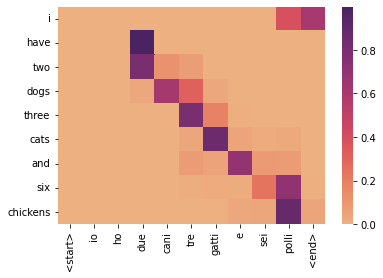

Predicted Translation:  i have two dogs three cats and six chickens
Italian Sentence:  i trasporti sono stati programmati
Acutual Translation:  transportation has been arranged
Attention Weights: 


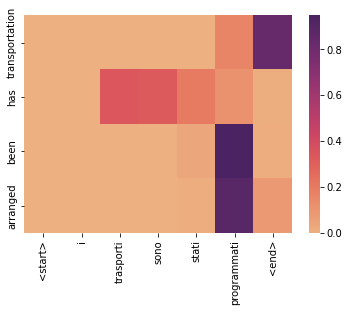

Predicted Translation:  transportation has been arranged
Italian Sentence:  state arrossendo
Acutual Translation:  are you blushing
Attention Weights: 


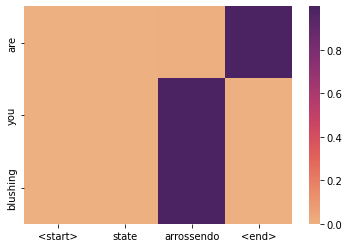

Predicted Translation:  are you blushing
Italian Sentence:  sono stato il primo insegnante di francese di tom
Acutual Translation:  i was tom is first french teacher
Attention Weights: 


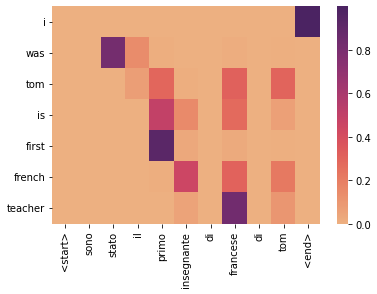

Predicted Translation:  i was tom is first french teacher
Italian Sentence:  perché tom vuole mollare
Acutual Translation:  why does tom want to quit
Attention Weights: 


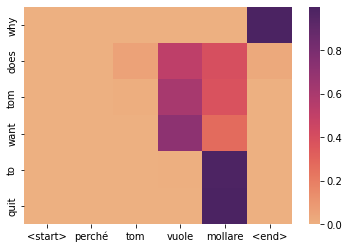

Predicted Translation:  why does tom want to quit


In [ ]:
for i,row in train.sample(5).iterrows():
    print('='*80)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model_dot,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
bleu_scores = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model_dot,row['italian'],False)
    reference = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores.append(bleu.sentence_bleu(reference, translation))
    
print("Average BLUEU score for 1000 Seneteces is :", np.mean(bleu_scores))

Average BLUEU score for 1000 Seneteces is : 0.8018026612171132


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,  restore_best_weights=True)

In [ ]:
model_general = encoder_decoder(25,26,vocab_size_eng,'general')
optimizer = tf.keras.optimizers.Adam()
model_general.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size

In [ ]:
model_general.fit(train_dataloader,
                     steps_per_epoch=train_steps,
                     epochs=25,
                     validation_data=vaidation_dataloader,
                     validation_steps=valid_steps,
                     callbacks=[tensorboard_callback,early_stop],
                     verbose=1)

Epoch 1/25
546/546 [==============================] - 205s 292ms/step - loss: 1.3290 - val_loss: 1.1855
Epoch 2/25
546/546 [==============================] - 153s 280ms/step - loss: 1.0401 - val_loss: 0.8862
Epoch 3/25
546/546 [==============================] - 155s 283ms/step - loss: 0.7785 - val_loss: 0.6874
Epoch 4/25
546/546 [==============================] - 155s 283ms/step - loss: 0.6081 - val_loss: 0.5486
Epoch 5/25
546/546 [==============================] - 155s 283ms/step - loss: 0.4816 - val_loss: 0.4456
Epoch 6/25
546/546 [==============================] - 155s 284ms/step - loss: 0.3875 - val_loss: 0.3722
Epoch 7/25
546/546 [==============================] - 155s 284ms/step - loss: 0.3187 - val_loss: 0.3223
Epoch 8/25
546/546 [==============================] - 155s 284ms/step - loss: 0.2672 - val_loss: 0.2857
Epoch 9/25
546/546 [==============================] - 155s 283ms/step - loss: 0.2293 - val_loss: 0.2580
Epoch 10/25
546/546 [==============================] - 155s 284m

In [ ]:
model_general.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1647918   
                                                                 
 decoder_3 (Decoder)         multiple                  5371275   
                                                                 
Total params: 7,019,193
Trainable params: 7,019,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import seaborn as sns
def predict(model_general,data,visualize=True):
    inputs = data.split(' ')
    encoder_seq = tknizer_ita.texts_to_sequences([data])
    encoder_seq = pad_sequences(encoder_seq, maxlen=25, dtype='int32', padding='post')
    encoder_output,state_h,state_c = model_general.encoder(encoder_seq,model_general.encoder.initialize_states(1))
    input_to_decoder = np.array(tknizer_eng.texts_to_sequences(['<start>']))
    outputs = []
    attention_wts = []
    count = 0
    while True:
        output,state_h,state_c,attention_weights,context_vector=model_general.decoder.onestepdecoder(input_to_decoder,
                                                                                    encoder_output,
                                                                                    state_h,
                                                                                    state_c)
        eng_id = tf.math.argmax(output[0]).numpy()
        eng_word = tknizer_eng.sequences_to_texts([[eng_id]])
        input_to_decoder = np.array(tknizer_eng.texts_to_sequences(eng_word))
        count += 1
        if count == 26 or eng_word[0] == '<end>':
            break
        outputs.append(eng_word[0])
        attention_wts.append(tf.squeeze(attention_weights).numpy()[:len(inputs)])
    
    attention_wts = np.array(attention_wts)
    if visualize:
        sns.heatmap(attention_wts,xticklabels=inputs,yticklabels=outputs,cmap="flare")
        plt.show()
    return(outputs,np.array(attention_wts))

Italian Sentence:  quanto pensi che sia idiota
Acutual Translation:  how big an idiot do you think i am
Attention Weights: 


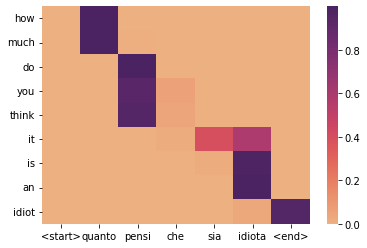

Predicted Translation:  how much do you think it is an idiot
Italian Sentence:  cè la vita su altri mondi
Acutual Translation:  is there life on other worlds
Attention Weights: 


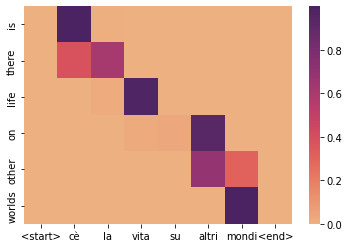

Predicted Translation:  is there life on other worlds
Italian Sentence:  ciò nonostante non sono brava a parlare in inglese
Acutual Translation:  however i am not good at speaking english
Attention Weights: 


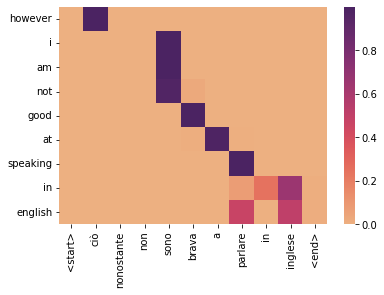

Predicted Translation:  however i am not good at speaking in english
Italian Sentence:  erano soldati
Acutual Translation:  they were soldiers
Attention Weights: 


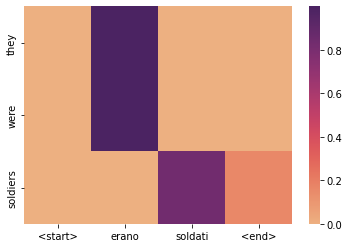

Predicted Translation:  they were soldiers
Italian Sentence:  tom non si sta dimenticando qualcosa
Acutual Translation:  is not tom forgetting something
Attention Weights: 


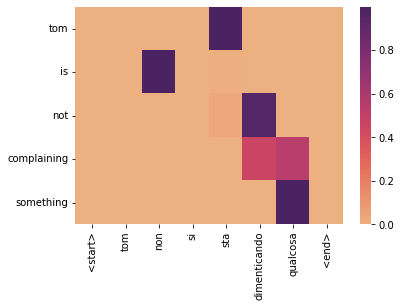

Predicted Translation:  tom is not complaining something


In [ ]:
for i,row in train.sample(5).iterrows():
    print('='*80)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model_general,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu
bleu_scores = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model_general,row['italian'],False)
    reference = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores.append(bleu.sentence_bleu(reference, translation))
    
print("Average BLUEU score for 1000 Seneteces is :", np.mean(bleu_scores))

Average BLUEU score for 1000 Seneteces is : 0.8179711147055166


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [29]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,  restore_best_weights=True)

In [30]:
model_concat = encoder_decoder(25,26,vocab_size_eng,'concat')
optimizer = tf.keras.optimizers.Adam()
model_concat.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size

In [32]:
model_concat.fit(train_dataloader,
                     steps_per_epoch=train_steps,
                     epochs=25,
                     validation_data=vaidation_dataloader,
                     validation_steps=valid_steps,
                     callbacks=[tensorboard_callback,early_stop],
                     verbose=1)

Epoch 1/25
546/546 [==============================] - 399s 728ms/step - loss: 1.1666 - val_loss: 0.9982
Epoch 2/25
546/546 [==============================] - 388s 711ms/step - loss: 0.8557 - val_loss: 0.7351
Epoch 3/25
546/546 [==============================] - 382s 700ms/step - loss: 0.6461 - val_loss: 0.5733
Epoch 4/25
546/546 [==============================] - 382s 700ms/step - loss: 0.5022 - val_loss: 0.4605
Epoch 5/25
546/546 [==============================] - 382s 700ms/step - loss: 0.3985 - val_loss: 0.3812
Epoch 6/25
546/546 [==============================] - 383s 701ms/step - loss: 0.3242 - val_loss: 0.3242
Epoch 7/25
546/546 [==============================] - 383s 701ms/step - loss: 0.2701 - val_loss: 0.2848
Epoch 8/25
546/546 [==============================] - 382s 699ms/step - loss: 0.2302 - val_loss: 0.2573
Epoch 9/25
546/546 [==============================] - 382s 700ms/step - loss: 0.1992 - val_loss: 0.2349
Epoch 10/25
546/546 [==============================] - 382s 699m

In [33]:
model_concat.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1648168   
                                                                 
 decoder_3 (Decoder)         multiple                  5415547   
                                                                 
Total params: 7,063,715
Trainable params: 7,063,715
Non-trainable params: 0
_________________________________________________________________


In [34]:
import seaborn as sns
def predict(model_concat,data,visualize=True):
    inputs = data.split(' ')
    encoder_seq = tknizer_ita.texts_to_sequences([data])
    encoder_seq = pad_sequences(encoder_seq, maxlen=25, dtype='int32', padding='post')
    encoder_output,state_h,state_c = model_concat.encoder(encoder_seq,model_concat.encoder.initialize_states(1))
    input_to_decoder = np.array(tknizer_eng.texts_to_sequences(['<start>']))
    outputs = []
    attention_wts = []
    count = 0
    while True:
        output,state_h,state_c,attention_weights,context_vector=model_concat.decoder.onestepdecoder(input_to_decoder,
                                                                                    encoder_output,
                                                                                    state_h,
                                                                                    state_c)
        eng_id = tf.math.argmax(output[0]).numpy()
        eng_word = tknizer_eng.sequences_to_texts([[eng_id]])
        input_to_decoder = np.array(tknizer_eng.texts_to_sequences(eng_word))
        count += 1
        if count == 26 or eng_word[0] == '<end>':
            break
        outputs.append(eng_word[0])
        attention_wts.append(tf.squeeze(attention_weights).numpy()[:len(inputs)])
    
    attention_wts = np.array(attention_wts)
    if visualize:
        sns.heatmap(attention_wts,xticklabels=inputs,yticklabels=outputs,cmap="flare")
        plt.show()
    return(outputs,np.array(attention_wts))

Italian Sentence:  io non posso sopportare questo rumore
Acutual Translation:  i cannot stand this noise
Attention Weights: 


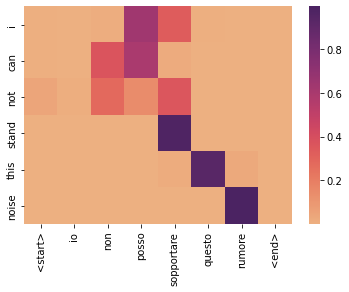

Predicted Translation:  i can not stand this noise
Italian Sentence:  se hai un problema parla con tom
Acutual Translation:  if you have a problem talk to tom
Attention Weights: 


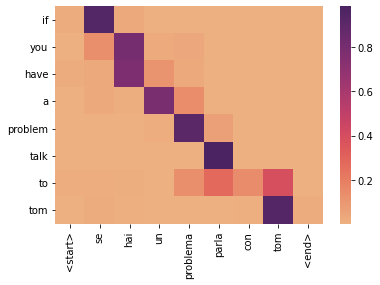

Predicted Translation:  if you have a problem talk to tom
Italian Sentence:  voi sarete mie
Acutual Translation:  you will be mine
Attention Weights: 


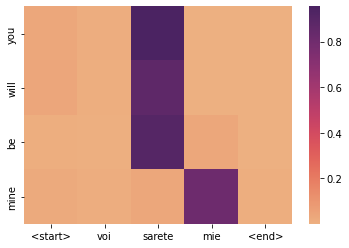

Predicted Translation:  you will be mine
Italian Sentence:  non sei un prete
Acutual Translation:  are not you a priest
Attention Weights: 


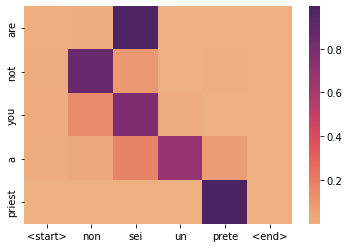

Predicted Translation:  are not you a priest
Italian Sentence:  le cose non sono andate come tom sperava
Acutual Translation:  things did not go the way tom had hoped
Attention Weights: 


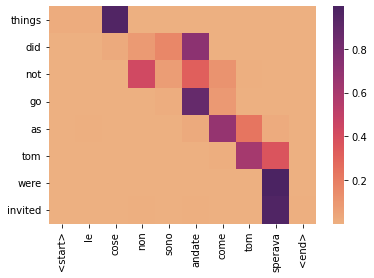

Predicted Translation:  things did not go as tom were invited


In [35]:
for i,row in train.sample(5).iterrows():
    print('='*80)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model_concat,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

<font color='blue'>**Calculate BLEU score**</font>

In [36]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu
bleu_scores = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model_concat,row['italian'],False)
    reference = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores.append(bleu.sentence_bleu(reference, translation))
    
print("Average BLUEU score for 1000 Seneteces is :", np.mean(bleu_scores))

Average BLUEU score for 1000 Seneteces is : 0.8064102714326871


In [ ]:
# Write your observations on each of the scoring function

In [37]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Architecture", "BLEU score"]
x.add_row(["Model-Encoder_decoder", "0.620"])
x.add_row(["Model_dot", "0.801"])
x.add_row(["Model_general", "0.817"])
x.add_row(["Model_concat", " 0.806"])
print(x)

+-----------------------+------------+
|      Architecture     | BLEU score |
+-----------------------+------------+
| Model-Encoder_decoder |   0.620    |
|       Model_dot       |   0.801    |
|     Model_general     |   0.817    |
|      Model_concat     |    0.806   |
+-----------------------+------------+
